# Care - 2D Example for time points between 390 and 399

Here, the volumetric images from camera CM02 have been flipped and translated. Next, the CM02 images have been registered pixel-wise. Q0
## CM02: Q0_o, Q1_o, Q2_o, Q3_o, Q4_o, Q4_i, Q3_i, Q2_i, Q1_i, Q0_i
## CM03: Q0_i, Q1_i, Q2_i, Q3_i, Q4_i, Q4_o, Q3_o, Q2_o, Q1_o, Q0_o

In [1]:
# We import all our dependencies.
from n2v.models import N2V
import numpy as np
from matplotlib import pyplot as plt
from tifffile import imread, imwrite
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from csbdeep.io import save_tiff_imagej_compatible
from csbdeep.models import CARE
import glob
import copy

Using TensorFlow backend.


In [2]:
quality='Q0/'

In [3]:
# A previously trained model is loaded by creating a new Care object without providing a 'config'.  
model = CARE(config=None, name='care_2D_kellerlab_with_normalization_with_HandRegistration_float64_Q0_ne300_es250', basedir='models')

Loading network weights from 'weights_best.h5'.


## Load images from CM02. 

In [4]:
filenames = glob.glob("/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM02_flipped/*.tif")
filenames.sort()
imgs = [imread(img).astype('float64') for img in filenames]

print(len(imgs))
print(imgs[0].shape)

10
(70, 896, 576)


## Take only the last 35  z-slices as input from CM02

In [5]:
X_CM02=[]
for i in range(len(imgs)):
    temp=imgs[i][-35:, ...]
    X_CM02.append(temp)
print(X_CM02[5].shape)

(35, 896, 576)


## Take only the first 35 z-slices as output from CM02

In [6]:
Y_CM02=[]
for i in range(len(imgs)):
    temp=imgs[i][:35, ...]
    Y_CM02.append(temp)
print(Y_CM02[5].shape)

(35, 896, 576)


## Load images from CM03

In [7]:
filenames = glob.glob("/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM03/*.tif")
filenames.sort()
imgs = [imread(img).astype('float64') for img in filenames]

print("Typical shape:",  imgs[0].shape)
print("Typical datatype:", imgs[0].dtype)

Typical shape: (70, 896, 576)
Typical datatype: float64


## Take only the first 35 z-slices from CM03 as input

In [8]:
X_CM03=[]
for i in range(len(imgs)):
    temp=imgs[i][:35, ...]
    X_CM03.append(temp)
print(X_CM03[5].shape)

(35, 896, 576)


## Take only the last 35 z-slices from CM03 as output

In [9]:
Y_CM03=[]
for i in range(len(imgs)):
    temp=imgs[i][-35:, ...]
    Y_CM03.append(temp)
print(Y_CM03[5].shape)

(35, 896, 576)


## Combine X_CM02 and X_CM03

In [10]:
input_train=X_CM02+X_CM03
print(len(input_train))
print(input_train[5].shape)

20
(35, 896, 576)


In [11]:
imgsY=Y_CM03+Y_CM02
print(len(imgsY))
print(imgsY[5].shape)

20
(35, 896, 576)


## At this point, we chop off the first and last 60 pixels from the X-dimension and Y-dimension and then normalize, in order to train subsequently

In [12]:
input_train_chopped=[]
for i in range(len(input_train)):
    input_train_chopped.append(input_train[i][:, 60:-60, 60:-60])

## Copy the mean and std from the training notebooks

In [13]:
mean=np.array(102.89431263807069).astype('float64')
std=np.array(5.411731522138403).astype('float64')

In [14]:
input_train_chopped_normalized=copy.deepcopy(input_train_chopped)
for i in range(len(input_train_chopped_normalized)):
    input_train_chopped_normalized[i]=(input_train_chopped[i]-mean)/std


In [15]:
pred_train=copy.deepcopy(input_train_chopped_normalized)
for i in range(len(input_train_chopped_normalized)):
    for j in range(input_train_chopped_normalized[i].shape[0]):
        img=input_train_chopped_normalized[i][j, ..., np.newaxis]
        result_image=model.predict(img, axes='YXC', n_tiles=(4,4,1), normalizer= None)
        pred_train[i][j, ..., np.newaxis]=result_image

100%|██████████| 16/16 [00:00<00:00, 31.33it/s]  


100%|██████████| 16/16 [00:00<00:00, 32.73it/s]  


100%|██████████| 16/16 [00:00<00:00, 33.00it/s]  


100%|██████████| 16/16 [00:00<00:00, 32.10it/s]  


100%|██████████| 16/16 [00:00<00:00, 32.59it/s]  


In [16]:
print(len(pred_train))
print(pred_train[0].shape)
print(pred_train[0].dtype)

20
(35, 776, 456)
float64


## Denormalize the predictions

In [17]:
pred_train_denormalized=copy.deepcopy(pred_train)
for i in range(len(pred_train)):
    pred_train_denormalized[i] = pred_train[i]*std + mean

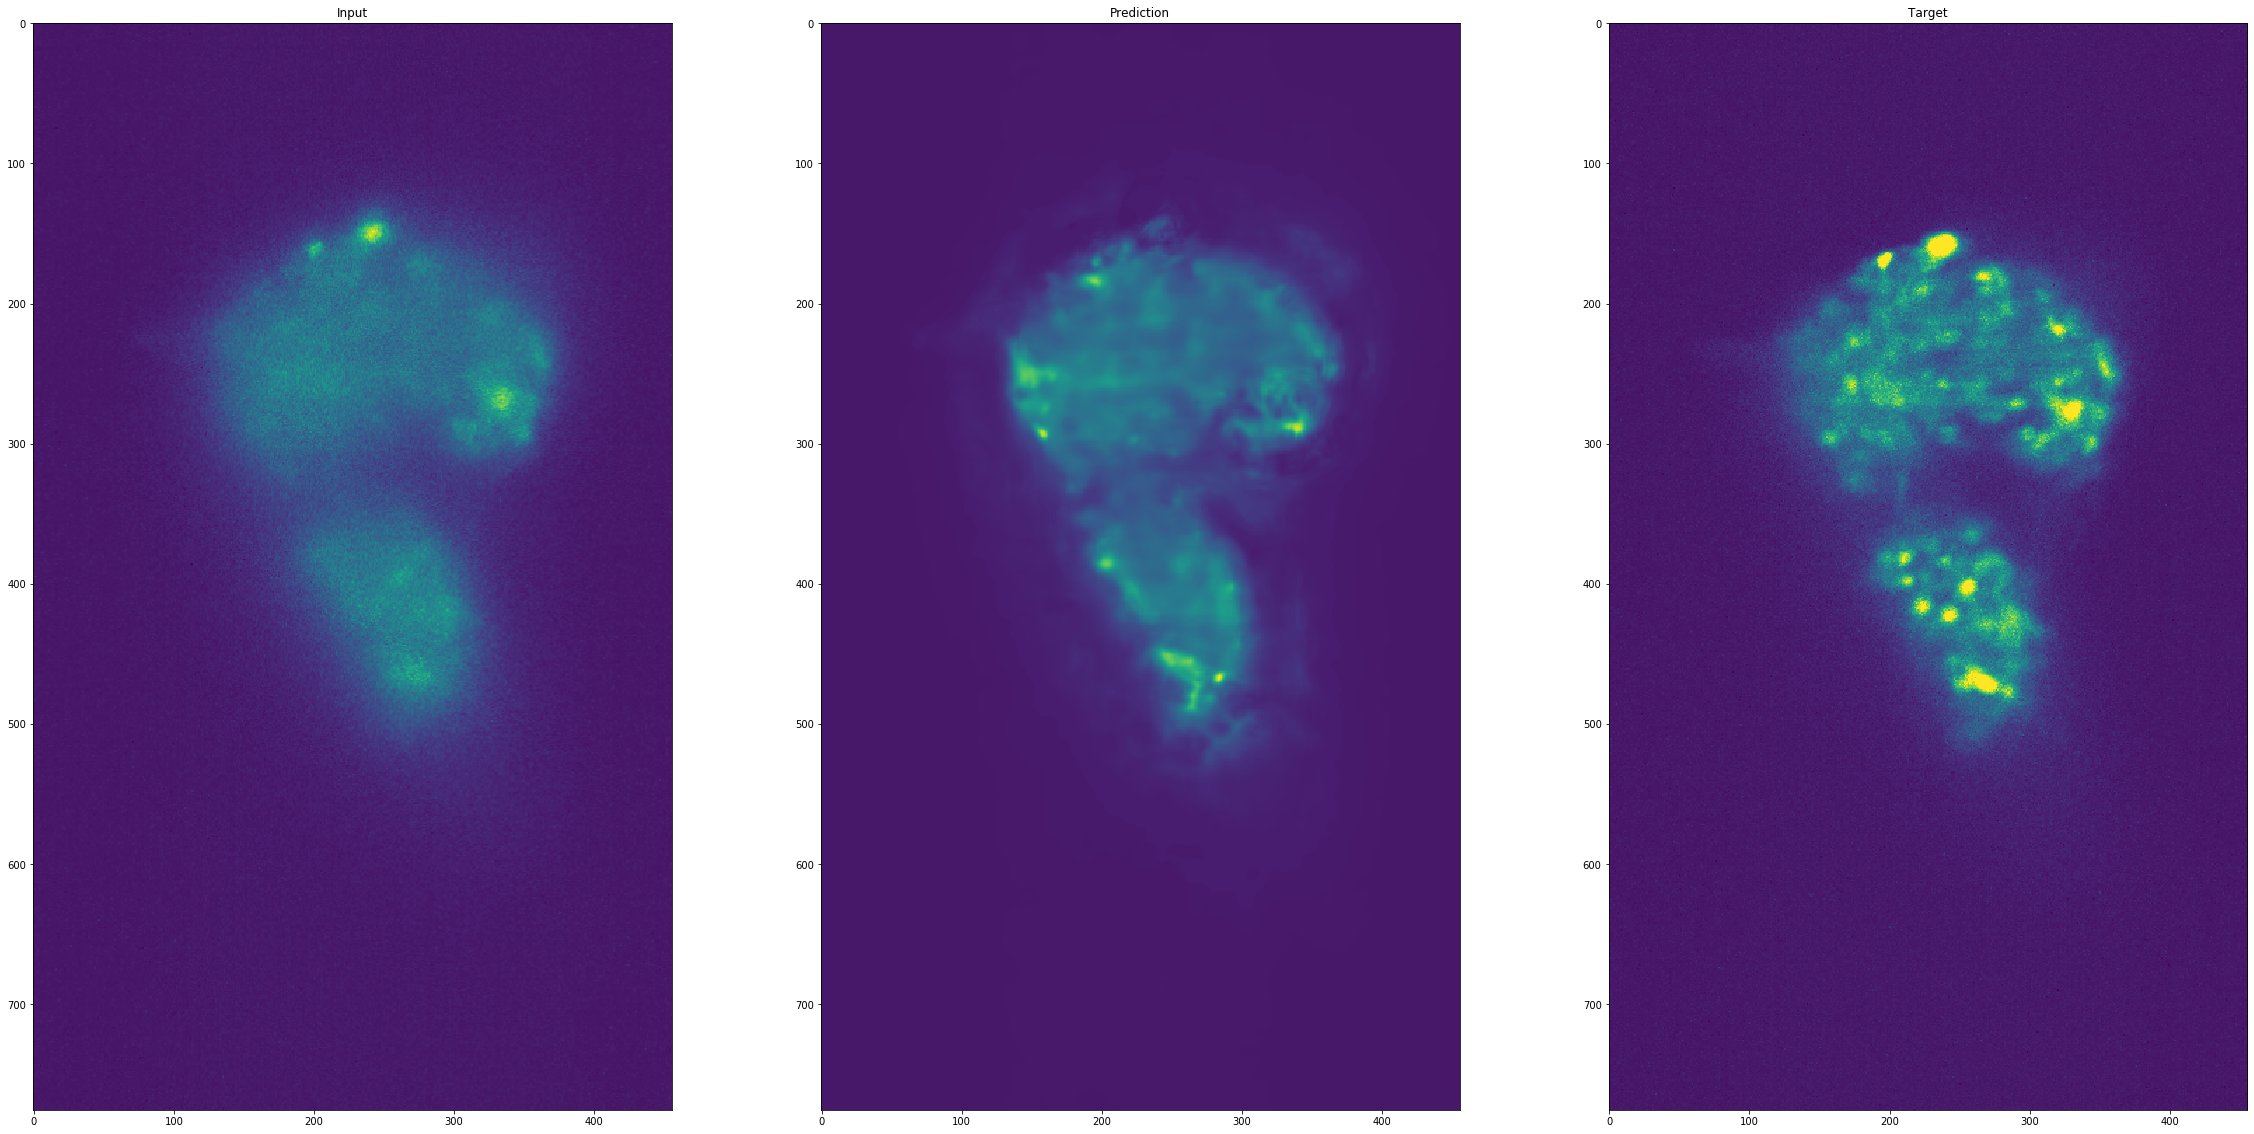

In [26]:
slice=22
im=5
vmin=np.min(input_train_chopped[im][slice, ...])
vmax=np.max(input_train_chopped[im][slice, ...])

# Let's look at the results.
plt.figure(figsize=(40,20))
plt.subplot(1,3,1)
plt.imshow(input_train_chopped[im][slice, ...], vmin=vmin, vmax=vmax)
plt.title('Input');

plt.subplot(1,3,2)
plt.imshow(pred_train_denormalized[im][slice, ...], vmin=vmin, vmax=vmax)
plt.title('Prediction');

plt.subplot(1,3,3)
plt.imshow(imgsY[im][slice, 60:-60, 60:-60], vmin=vmin, vmax=vmax)
plt.title('Target');

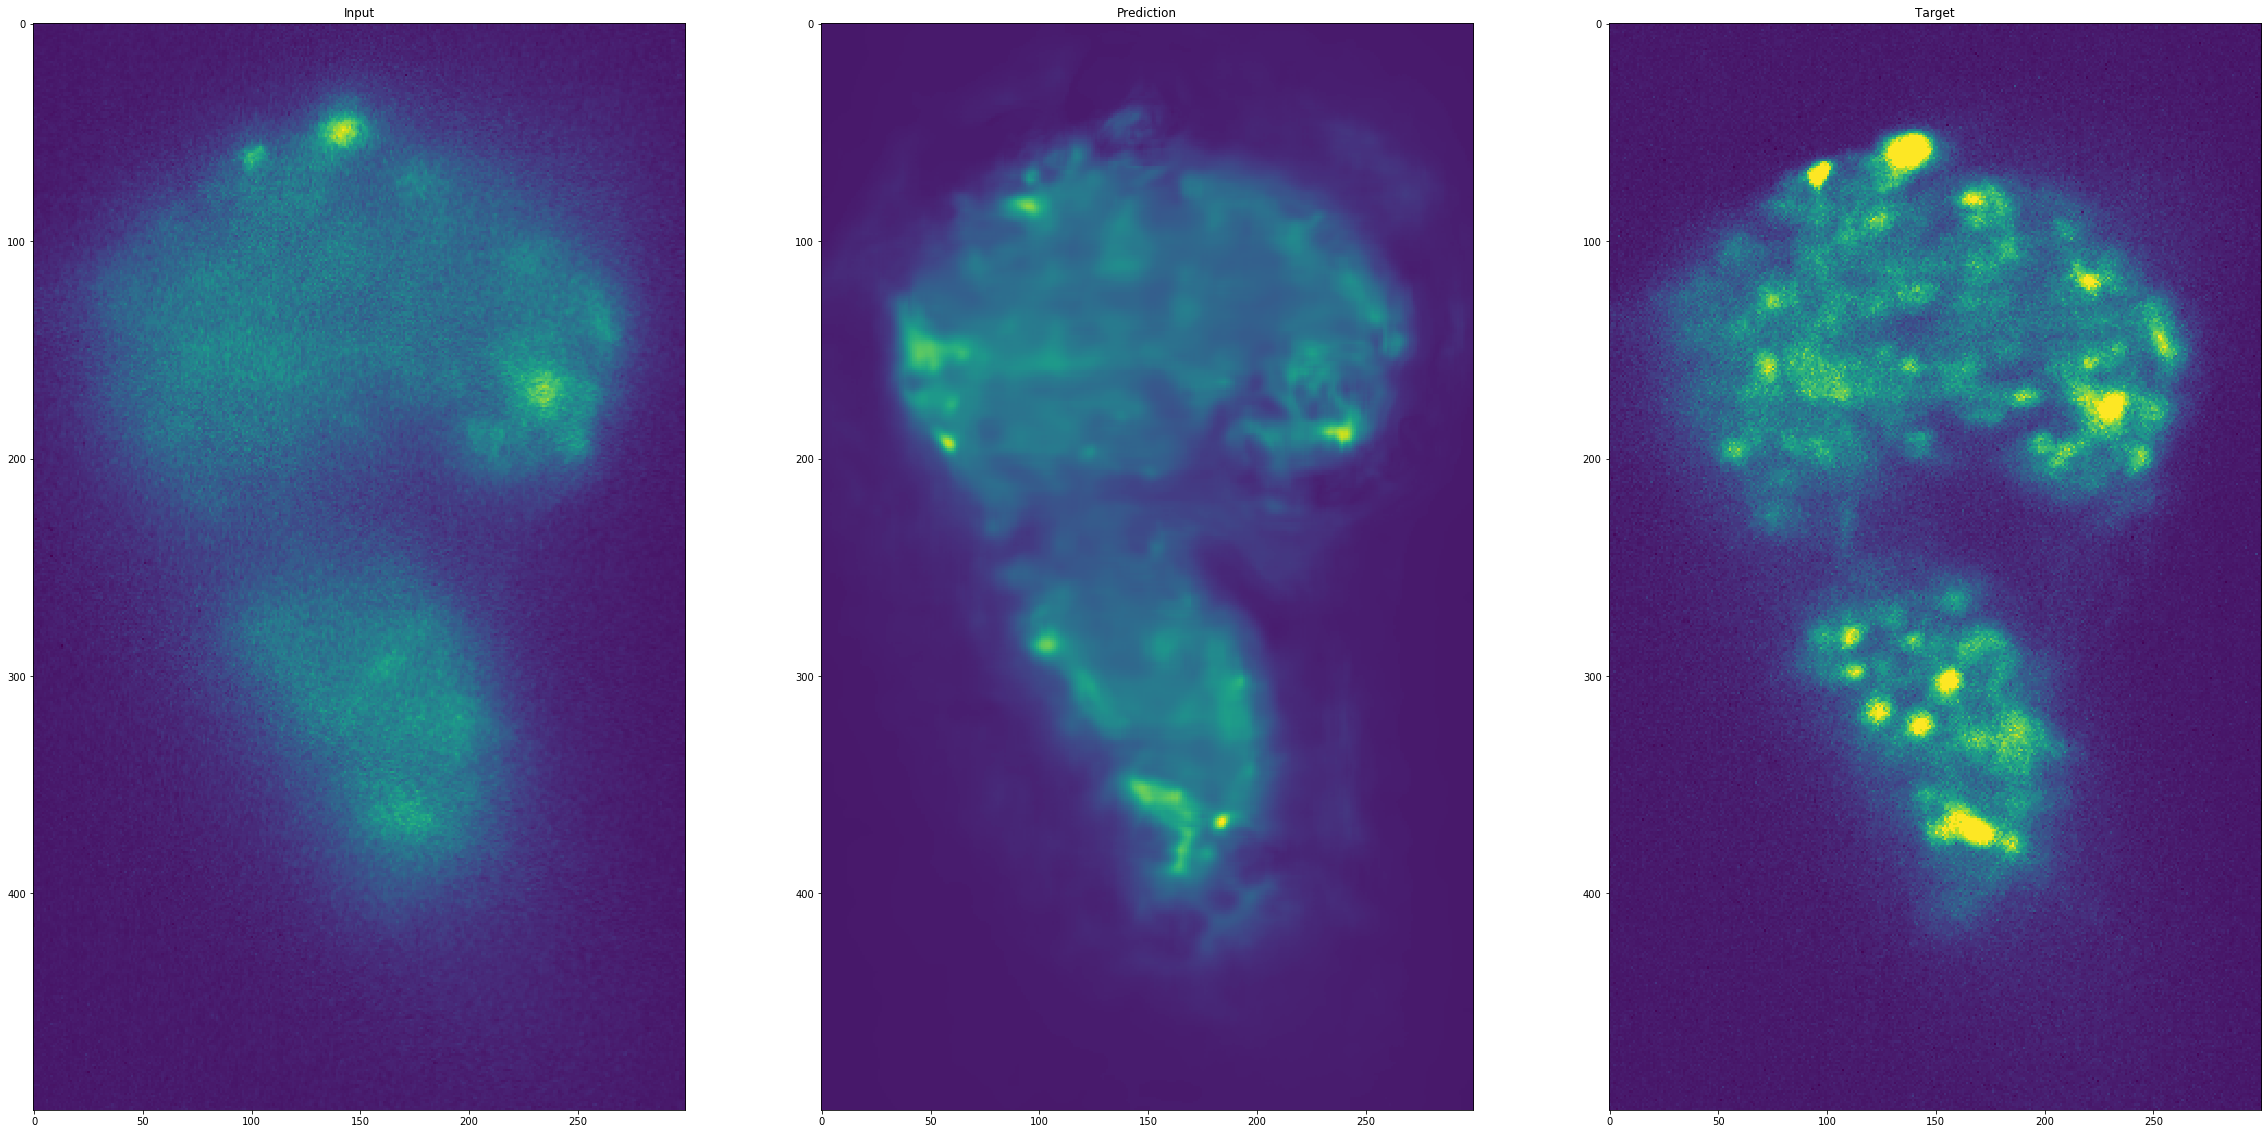

In [24]:
slice=22
ymin=100
ymax=600
xmin=100
xmax=400
im=5
vmin=np.min(input_train_chopped[im][slice, ...])
vmax=np.max(input_train_chopped[im][slice, ...])

# Let's look at the results.
plt.figure(figsize=(40,20))
plt.subplot(1,3,1)
plt.imshow(input_train_chopped[im][slice, ymin:ymax, xmin:xmax], vmin=vmin, vmax=vmax)
plt.title('Input');

plt.subplot(1,3,2)
plt.imshow(pred_train_denormalized[im][slice, ymin:ymax, xmin:xmax], vmin=vmin, vmax=vmax)
plt.title('Prediction');

plt.subplot(1,3,3)
imgsYtemp=imgsY[im][:, 60:-60, 60:-60]
plt.imshow(imgsYtemp[slice, ymin:ymax, xmin:xmax], vmin=vmin, vmax=vmax)
plt.title('Target');

## A brief look at how the intensity values have changed after training !

In [24]:

print(np.min(pred_train_denormalized[6][6, ...]))
print(np.max(pred_train_denormalized[6][6, ...]))
print(np.min(input_train_chopped[6][6, ...]))
print(np.max(input_train_chopped[6][6, ...]))


94.38265463501419
1202.7551688781457
79.0
501.0


## Reconstitute the images

In [42]:
quality='Q0_useForAll/'

In [43]:
for i in range(10):
    fileindex=390+i
    print(str(fileindex))
    complete=np.concatenate((Y_CM02[i][:, 60:-60, 60:-60], pred_train_denormalized[i]))
    imwrite("/home/lalit/Desktop/04_Data/KellerLabData/04_Denoised/01Sep2019/CM02/"+quality+str(fileindex)+".tif",np.array(complete, dtype='float32'))

390
391
392
393
394
395
396
397
398
399


In [44]:
for i in range(10, 20):
    fileindex=390+i-10
    print(str(fileindex))
    complete=np.concatenate((pred_train_denormalized[i], Y_CM03[i-10][:, 60:-60, 60:-60]))
    imwrite("/home/lalit/Desktop/04_Data/KellerLabData/04_Denoised/01Sep2019/CM03/"+quality+str(fileindex)+".tif",np.array(complete, dtype='float32'))

390
391
392
393
394
395
396
397
398
399
